# Проект 8 - Кафе в Москве

## Введение

**Описание проекта**

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов? Надо исследовать рынок общественных заведений в Москве.

**Описание данных**

Таблица `rest_data`.

1. `id` — идентификатор объекта
2. `object_name` — название объекта общественного питания
3. `chain` — сетевой ресторан
4. `object_type` — тип объекта общественного питания
5. `address` — адрес
6. `number` — количество посадочных мест

## Предобработка данных

Для начала проверим какие данные нам достались. Нас интересуют:

1. Названия колонок.
2. Артефакты в данных.
3. Типы данных.

Пойдем по порядку.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from IPython.display import display
plt.style.use('default')

# Save raw datasets in case we need them
try:
    raw_cafe = pd.read_csv('rest_data.csv')
except:
    raw_cafe = pd.read_csv('/datasets/rest_data.csv')
    
# Constants, which we will need later
FIG_WIDTH = 8
FIG_HEIGHT = 5
sns.set(rc={"figure.figsize":(FIG_WIDTH, FIG_HEIGHT)})


In [3]:
# Let's have a look what is inside
display(raw_cafe.head(5))
raw_cafe.info()


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Очень красивая таблица. Похоже, у нас нет пропущенных значений, строк-дубликатов и типы данных в колоноках заданы верно. Правда, у нас есть проблемы посерьезнее: названия ресторанов, которые нам придется использовать дальше, не являются стандартными. Мы можем попробовать привести все значения к стандартному регистру, но более сложные упражнения придется отложить.

В качестве дополнительного упражнения можем переименовать колонки `object_name`, `object_type` и `number` чтобы были более репрезентативны, а также сделать нормальный флаг `True` / `False` для колонки `chain`.

In [4]:
# Clean dataset
df_cafe = raw_cafe.copy()
df_cafe = (
    df_cafe
    .rename(
        columns={
            'object_name': 'name',
            'object_type': 'type',
            'number': 'seats'
        }
    )
)
df_cafe['chain'] = (
    df_cafe
    .chain
    .replace({
        'да': True,
        'нет': False
    })
)
df_cafe = df_cafe.astype({'chain': bool})
df_cafe['name'] = df_cafe.name.str.title()


## Исследование рынка

Посмотрим, какие зависимости на рынке мы сможем найти: сколько есть заведений каждого типа, как у них с посадочными местами, где они расположены.

Снова пойдем по порядку.

### Количество локаций

Total number of locations: 15366


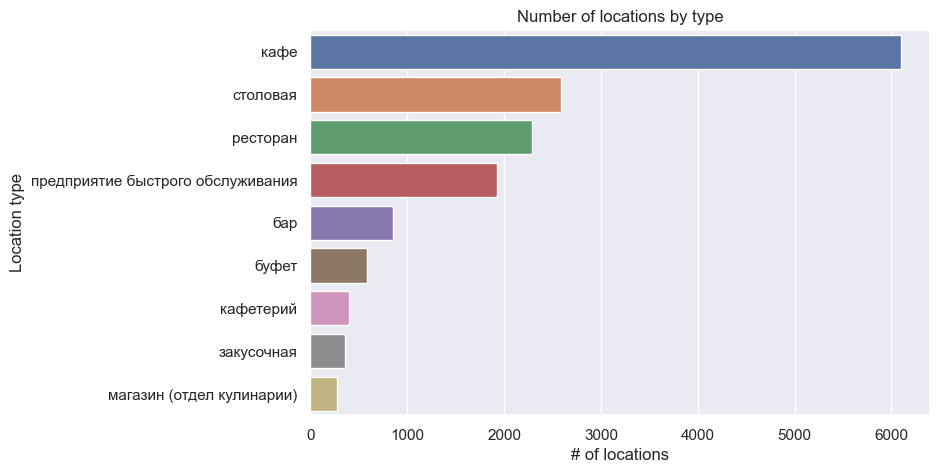

In [5]:
# Number of cafes per type
print('Total number of locations:', df_cafe.id.count())
ax = sns.countplot(
    data=df_cafe,
    y='type',
    order=df_cafe.type.value_counts().index
);
ax.set_title('Number of locations by type');
ax.set_xlabel('# of locations');
ax.set_ylabel('Location type');

Выводы: Москва - это город кафе. Их более 6К из общего количества в 15К. Это ожидаемо: сходить на чашечку кофе - любимое занятие молодежи (предположительно). Следом идут столовые и рестораны, которых чуть более 2К. И затем уже остальные заведения. С одной стороны, такая ситуация - это хорошо для нас, потому что рынок есть. С другой стороны - это совсем не голубой океан и надо иметь хорошее уникальное предложение, чтобы как-то выделяться из толпы.

Total number of chain restaurants: 2968
Total number of independent restaurants: 12398


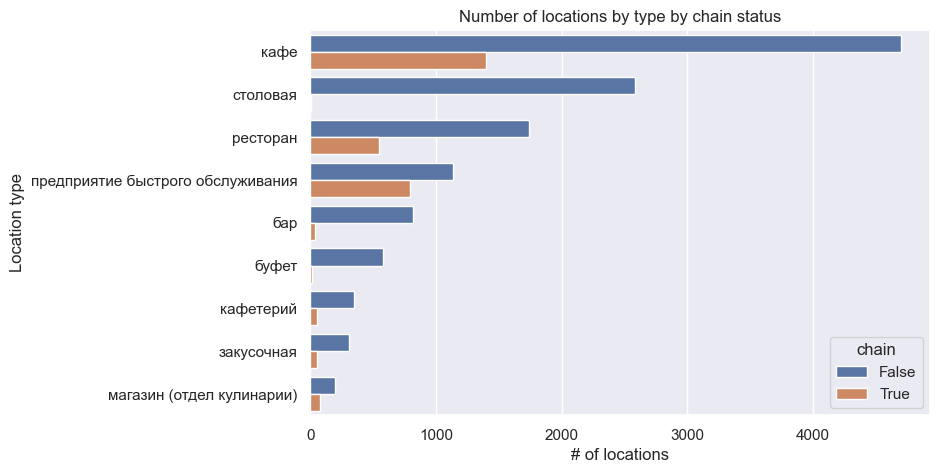

In [6]:
# Number of cafes per type depending on chain status
print('Total number of chain restaurants:', df_cafe[df_cafe.chain == True].id.count())
print('Total number of independent restaurants:', df_cafe[df_cafe.chain == False].id.count())
ax = sns.countplot(
    data=df_cafe,
    y='type',
    order=df_cafe.type.value_counts().index,
    hue='chain'
);
ax.set_title('Number of locations by type by chain status');
ax.set_xlabel('# of locations');
ax.set_ylabel('Location type');

Выводы: в Москве более 80% заведений несетевые. Это хороший знак, значит для стартаперов есть место. При этом, более 4.5К независимых локаций - это кафе.

### Количество мест

Вторым упражнением посмотрим на среднее количество мест в каждом типе заведений.

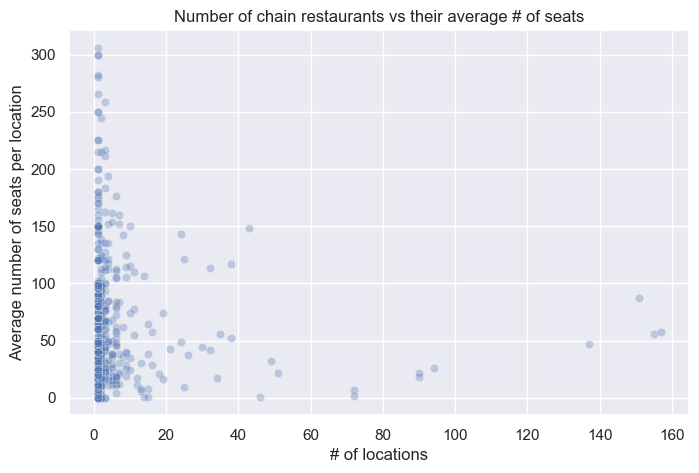

In [7]:
# Number of cafes per type depending on chain status
df_temp = (
    pd.pivot_table(
        data=df_cafe[df_cafe.chain == True],
        index='name',
        values=['id', 'seats'],
        aggfunc={'id': 'count', 
                 'seats': 'mean'}
    )
    .reset_index()
)
df_temp.columns = ['name', 'location_count', 'seats_avg']

ax = sns.scatterplot(data=df_temp, x='location_count', y='seats_avg', alpha=0.3);
ax.set_title('Number of chain restaurants vs their average # of seats');
ax.set_xlabel('# of locations');
ax.set_ylabel('Average number of seats per location');

Выводы: для сетевых заведений больше характерно мало заведений, но с большим количеством посадочных мест. Возможно, это связано с арендой платой и эффектами масштаба. Скорей всего, одно заведение на 100 кв. м. дешевле, чем 2 заведения по 50 кв. м.

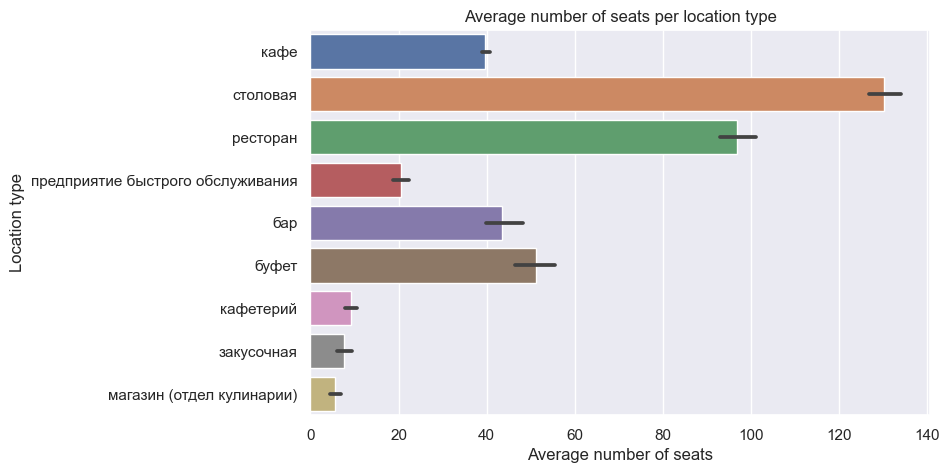

In [8]:
# Mean number of seats by location type
ax = sns.barplot(
    data=df_cafe,
    x='seats',
    y='type',
    order=df_cafe.type.value_counts().index,
    estimator=np.mean
);
ax.set_title('Average number of seats per location type');
ax.set_xlabel('Average number of seats');
ax.set_ylabel('Location type');

Выводы: в среднем, самые большие заведения - это столовые и рестораны (100 и более посадочных мест). За ними идут буфеты, бары и кафе с 40-50 местами. И потом более мелкие заведения. Похоже, наше заведение также должно иметь около 40 мест.

### Расположение локаций

В последнем разделе посмотрим на каких улицах находится больше всего ресторанов, и на каких улицах их всего по одному. Нам понадобится выделить название улицы из адреса ресторана. Предположим, что все локации расположены в Москве и формат адреса `город, улица, дом`. Это не работает для всех записей, но справедливо для большинства.

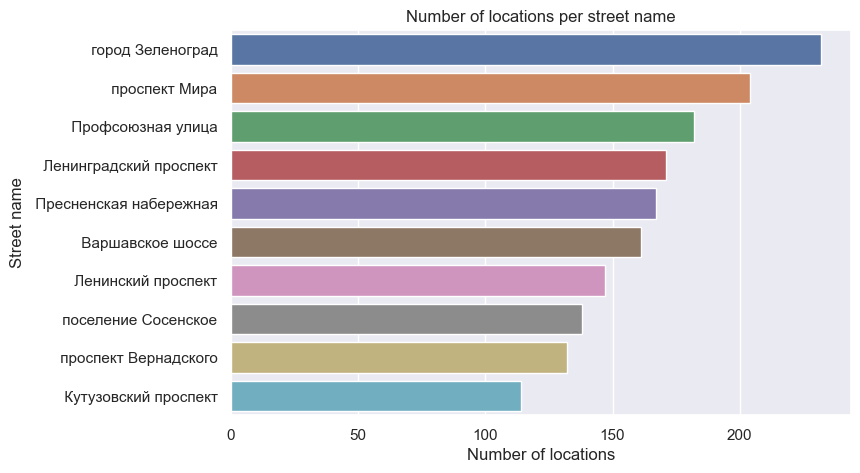

In [9]:
# Get street column from address
# Split address column by commas and then take only street from the result
df_cafe['street_name'] = df_cafe.address.str.split(',', expand=True)[1]
df_temp = (
    pd.pivot_table(
        data=df_cafe,
        index='street_name',
        values='id',
        aggfunc='count'
    )
    .reset_index()
    .sort_values(by='id', ascending=False)
    .head(10)
)
df_temp.columns = ['street_name', 'locations_count']

# Number of locations per street name - top-10
ax = sns.barplot(
    data=df_temp,
    x='locations_count',
    y='street_name',
    order=df_temp.street_name.value_counts().index
);
ax.set_title('Number of locations per street name');
ax.set_xlabel('Number of locations');
ax.set_ylabel('Street name');

Выводы: все эти улицы - одни из самых больших в Москве и расположены в центре города (кроме города Зеленограда - похоже, это просто артефакт выделения названий улиц).

In [10]:
# Number of streets with only one location
df_temp = (
    pd.pivot_table(
        data=df_cafe,
        index='street_name',
        values='id',
        aggfunc='count'
    )
    .reset_index()
    .sort_values(by='id', ascending=True)
)
df_temp.columns = ['street_name', 'locations_count']
print(
    'Number of streets with only one location: ',
    df_temp[df_temp.locations_count == 1].locations_count.sum()
)
display(df_temp.head(10))

Number of streets with only one location:  579


,street_name,locations_count
869,Новопресненский переулок,1
451,Вяземская улица,1
1798,улица Раевского,1
1176,Таёжная улица,1
454,Газгольдерная улица,1
1173,Тарханская улица,1
1172,Тарусская улица,1
457,Гаражная улица,1
1179,Театральная аллея,1
458,Гвардейская улица,1


Выводы: похоже, все эти улицы маленькие и расположены в спальных районах Москвы. Скорей всего поэтому на них так мало заведений.

## Общие выводы



Подведем итоги анализа рынка и сделаем небольшую [презентацию](https://1drv.ms/b/s!ArlflOrz4XZqh_wQZrYAnZP8_H2PtA?e=3y66rq):

1. В Москве более 15К различных заведений общественного питания. Более 30% из них - это различные (чаще независимые) кафе. Следующие 30% более-менее равномерно распределены между столовыми, ресторанами и предприятиями быстрого обслуживания.

2. Для сетевых заведений характерно небольшое количество локаций (порядка 10-20), но с большим количеством посадочных мест (более 40).

3. Самые популярные места для расположения объектов общественного питания - это большие центральные улицы Москвы, хотя на топ-10 их них приходится менее 20% локаций. В Москве также более 500 улиц с единичными заведениями. Большинство из них расположено в спальных районах Москвы.

4. Основное, что видно из анализа - рынок для кафе есть. К сожалению, он уже очень насыщен и надо будет сильно постараться, чтобы диверсифицировать себя от остальных кафе. Нам стоит ожидать, что наше заведение должно будет вмещать около 40 человек. Скорей всего, правильным решением будет расположить его как можно ближе к центру Москвы, несмотря на то, что там высокая конкуренция. Из-за высокого трафика, вероятно, это наш лучший шанс быстро вырастить бизнес.
